# Autoencoder for Out-of-Distribution Detection

This notebook implements an autoencoder neural network to detect out-of-distribution samples in tabular data.

## Problem Overview
- **Input**: 5000 samples of 257-dimensional vectors
- **Goal**: Train an autoencoder on in-distribution data to identify out-of-distribution samples
- **Approach**: Use reconstruction error as an anomaly score

## Implementation Plan
1. Data preparation and preprocessing
2. Autoencoder model definition
3. Model training on in-distribution data
4. Evaluation on both in-distribution and out-of-distribution data
5. Visualization and analysis

In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format='retina'

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
theoretical = pd.read_parquet('data/AQTheoretical10nm.x.parquet')

FileNotFoundError: [Errno 2] No such file or directory: 'data/AQTheoretical10nm.x.parquet'

In [ ]:
theoretical

,2083.33,2103.1,2122.86,2142.62,2162.39,2182.15,2201.91,2221.68,2241.44,2261.2,...,6964.84,6984.6,7004.36,7024.13,7043.89,7063.65,7083.41,7103.18,7122.94,7142.7
0,1.001209,1.000309,1.001357,1.002383,1.001461,1.002139,1.003361,1.000314,0.996871,0.996088,...,1.016524,1.019802,1.010029,1.000544,1.000082,1.000781,0.999188,0.999915,1.000945,0.999420
1,0.986604,0.995281,1.002130,0.996126,0.995195,1.002584,1.000086,0.993582,0.995439,0.989763,...,0.976620,0.975404,0.970220,0.965384,0.960566,0.941430,0.912571,0.899230,0.895408,0.875822
2,0.999583,0.999954,1.000567,0.999746,0.999609,1.000545,0.999919,0.998658,0.998344,0.995995,...,1.000037,0.999924,1.000012,1.000069,0.999944,0.999966,1.000075,0.999986,0.999931,1.000055
3,0.992324,0.997702,1.002247,0.997731,0.997150,1.002237,1.000015,0.995640,0.997600,0.993782,...,0.989815,0.989423,0.987169,0.984607,0.982459,0.973783,0.959250,0.951334,0.947492,0.934397
4,0.997188,0.999758,1.003315,0.998360,0.997398,1.003255,1.000953,0.993099,0.990155,0.978933,...,1.000151,0.999602,1.000103,1.000336,0.999682,0.999861,1.000390,0.999890,0.999666,1.000309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.000389,1.000161,1.000668,1.000660,1.000257,1.000639,1.000859,1.000308,1.000406,1.000833,...,1.000093,0.999884,0.999982,1.000129,0.999937,0.999911,1.000116,1.000015,0.999869,1.000063
4996,0.881522,0.857578,0.880428,0.884339,0.831655,0.802261,0.863898,0.955542,0.996267,0.999537,...,1.000170,0.999805,0.999957,1.000226,0.999901,0.999837,1.000197,1.000037,0.999771,1.000101
4997,0.999580,0.999954,1.000571,0.999744,0.999607,1.000549,0.999918,0.998650,0.998332,0.995967,...,1.000037,0.999923,1.000012,1.000070,0.999943,0.999966,1.000076,0.999986,0.999931,1.000055
4998,0.925166,0.915495,0.938859,0.936256,0.889675,0.869540,0.916871,0.976352,0.996537,0.996445,...,1.000061,0.999878,1.000017,1.000113,0.999911,0.999943,1.000120,0.999980,0.999888,1.000087


## 1. Data Preparation and Preprocessing


In [ ]:

np.random.seed(42)
#in_dist_df = theoretical

ood_df = pd.read_csv('/content/AQPracticalGasesSamples_20251116.csv').iloc[:,13:-7]
#ood_df = pd.read_csv('data/collected/GasesSamples.csv').iloc[:, 14:257+14]

# d001 = pd.read_csv('data/collected/2nd_floor_cafeteria_20251125.csv')
# d002 = pd.read_csv('data/collected/4th_floor_cafeteria_20251123.csv')
# d003 = pd.read_csv('data/collected/4th_floor_cafeteria_20251124_part1.csv')
# d004 = pd.read_csv('data/collected/4th_floor_cafeteria_20251124_part2.csv')
# in_dist_df = pd.concat([d001, d002, d003, d004], ignore_index=True).iloc[:, 3:]
#d001 = pd.read_csv('/content/2nd floor cafeteria 20251125 part2.csv')
#d002 = pd.read_csv('/content/2nd floor cafeteria 20251125 part3.csv')
#d003 = pd.read_csv('/content/2nd floor cafeteria 20251126.csv')
d004 = pd.read_csv('/content/2nd_floor_cafeteria_20251125.csv')
#d005 = pd.read_csv('/content/4th floor production lab 20251127 part2.csv')
d006 = pd.read_csv('/content/4th floor production lab 20251127 unknown gases included.csv')
#d007 = pd.read_csv('/content/4th floor production lab 20251127.csv')
d008 = pd.read_csv('/content/4th_floor_cafeteria_20251123.csv')
d009 = pd.read_csv('/content/4th_floor_cafeteria_20251124_part1.csv')
d010 = pd.read_csv('/content/4th_floor_cafeteria_20251124_part2.csv')
in_dist_df = pd.concat([d004, d008, d009, d010], ignore_index=True).iloc[:, 3:]

print(f"In-distribution data shape: {in_dist_df.shape}")
print(f"Out-of-distribution data shape: {ood_df.shape}")
print(f"Total samples: {len(in_dist_df) + len(ood_df)}")

In-distribution data shape: (36149, 257)
Out-of-distribution data shape: (24, 257)
Total samples: 36173


In [ ]:
in_dist_df

,2083.33334,2103.096507,2122.859675,2142.622843,2162.386011,2182.149179,2201.912347,2221.675515,2241.438683,2261.201851,...,6964.835823,6984.598991,7004.362158,7024.125326,7043.888494,7063.651662,7083.41483,7103.177998,7122.941166,7142.704334
0,0.976322,1.004424,0.992278,0.994330,1.003845,0.993670,0.991386,1.002513,1.010856,1.075457,...,1.000808,0.998232,0.998302,1.003421,1.005765,1.003065,1.000573,0.998096,0.993649,0.992224
1,0.006775,0.008780,0.013518,0.016657,0.020519,0.029440,0.037587,0.043280,0.054378,0.063509,...,0.026634,0.026178,0.025614,0.024808,0.024160,0.023521,0.022660,0.021940,0.021291,0.020384
2,0.990747,1.009028,0.979658,0.993693,1.011799,0.991755,0.992005,1.011883,1.012556,1.074380,...,1.005426,1.002114,1.001152,1.005406,1.007780,1.006628,1.001649,0.992974,0.990355,0.998069
3,0.984236,1.012082,0.993065,1.007329,1.015446,0.986945,0.988059,1.012667,1.014333,1.075299,...,1.003205,0.999078,0.999522,1.006150,1.009068,1.005159,1.000080,0.996563,0.994101,0.992669
4,1.003232,1.033210,1.002507,1.012701,1.022853,0.992155,0.984408,1.001448,1.006546,1.073255,...,0.999191,0.995936,0.997761,1.007336,1.007894,1.001773,1.002499,1.001519,0.991178,0.985786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36144,0.915565,0.953193,0.954563,0.938639,0.918669,0.920562,0.929450,0.935434,0.955081,1.022519,...,0.994062,0.991718,0.992207,0.995287,0.993027,0.996245,1.007110,1.002733,0.987851,0.992480
36145,0.912569,0.930066,0.945468,0.958431,0.946680,0.925906,0.923299,0.934421,0.958667,1.023554,...,0.994610,0.998965,0.999606,0.994289,0.989188,0.992918,1.001595,0.999429,0.989664,0.992948
36146,0.902672,0.924161,0.948737,0.939710,0.916771,0.912181,0.917017,0.928844,0.956812,1.024540,...,0.991030,0.989393,0.994229,0.995465,0.989622,0.995300,1.008752,1.001723,0.987105,0.995918
36147,0.893989,0.939867,0.964187,0.959298,0.935564,0.924262,0.924563,0.930045,0.954465,1.024158,...,0.997062,0.996770,0.996753,0.995347,0.989630,0.990832,1.002722,1.004823,0.993077,0.991142


In [ ]:
ood_df

,Device Temperature,2083.333321,2103.097076,2122.86083,2142.624585,2162.38834,2182.152094,2201.915849,2221.679604,2241.443358,...,6945.216972,6964.980727,6984.744482,7004.508236,7024.271991,7044.035746,7063.7995,7083.563255,7103.32701,7123.090765
0,25.334274,51.777783,52.374020,54.743199,56.362325,57.177145,57.608184,57.845787,57.988346,57.992509,...,62.151444,62.221431,62.167503,61.863683,61.434904,60.904618,60.248175,59.405629,58.690333,58.311051
1,25.491461,38.379993,37.790484,39.399870,40.977811,41.943785,42.507046,42.495459,42.174336,41.919713,...,25.384579,25.411849,25.464578,25.277286,24.926130,24.522551,24.205866,24.104317,24.009046,23.834981
2,25.615448,50.673319,49.739556,51.313699,53.208445,54.486301,55.282994,55.425882,55.287170,55.240050,...,27.337386,27.169509,27.239924,27.223811,27.007459,26.635022,26.229338,26.048204,25.922705,25.740477
3,25.748600,35.162204,35.448355,36.640370,37.635582,38.243557,38.655210,38.800210,38.611168,38.364879,...,9.919467,9.837334,9.887430,9.845426,9.655888,9.388050,9.177134,9.230052,9.272570,9.197426
4,25.863028,63.919465,62.097670,65.175382,68.544828,70.606986,71.607219,71.621860,71.622880,71.852504,...,37.113195,37.039887,37.197989,37.136416,36.831386,36.409794,36.078496,36.056967,35.961016,35.679802
5,25.986284,62.698746,60.882288,62.956250,65.708922,67.570699,68.656385,68.841397,68.894505,69.072656,...,49.958022,49.825318,49.813540,49.621888,49.242512,48.732934,48.182433,47.729141,47.332155,46.992828
6,26.213692,93.642757,93.278797,94.903899,96.168911,96.597217,96.417241,96.307841,96.798549,97.277577,...,95.793535,95.715817,95.687061,95.764703,95.861737,95.878219,95.689028,95.329344,95.087975,95.009875
7,26.499702,101.697783,114.955547,91.875551,81.794635,85.471985,100.645950,109.527272,95.017566,73.402995,...,93.353714,93.256119,93.670610,93.803684,93.527257,92.969619,92.380591,92.080549,91.756705,91.351706
8,26.586906,100.617313,112.950803,90.397366,81.068887,85.225155,100.610854,109.401659,94.701149,72.935897,...,92.647597,92.519974,92.934069,93.046419,92.728042,92.119485,91.489670,91.177003,90.818876,90.333252
9,26.697060,100.855299,112.949834,89.861820,80.544469,84.973878,100.774660,109.313373,93.888912,71.591968,...,92.473721,92.414441,92.908317,93.047086,92.720427,92.095467,91.474998,91.244984,90.985424,90.581822


In [ ]:
# Prepare data for training
# Split in-distribution data into train/validation sets
X_in_dist = in_dist_df.values
X_ood = ood_df.values

# Split in-distribution data (80% train, 20% validation)
X_train, X_val = train_test_split(X_in_dist, test_size=0.2, random_state=42)

# Combine validation and OOD data for evaluation
X_test = np.vstack([X_val, X_ood])
y_test = np.hstack([np.zeros(len(X_val)), np.ones(len(X_ood))])  # 0 = in-dist, 1 = OOD

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (28919, 257)
Validation data shape: (7230, 257)
Test data shape: (7254, 257)
Test labels shape: (7254,)


In [ ]:
# Data preprocessing - normalize features
scaler = MinMaxScaler()

# Fit scaler on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
#X_test_scaled = X_test

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # Autoencoder: input = target
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, torch.FloatTensor(y_test).to(device))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data preprocessing completed!")

Data preprocessing completed!


## 2. Autoencoder Model Definition

Define the neural network architecture for the autoencoder.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=257, latent_dim=16):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Output between 0 and 1 (matches MinMaxScaler)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        """Get the encoded representation"""
        return self.encoder(x)

# Initialize the model
model = Autoencoder(input_dim=257, latent_dim=16).to(device)
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=257, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=257, bias=True)
    (7): Sigmoid()
  )
)
Total parameters: 88017


## 3. Model Training

Train the autoencoder on in-distribution data using reconstruction loss.

In [ ]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

# Training parameters
num_epochs = 1000
best_val_loss = float('inf')
patience = 15
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []

In [ ]:
# Training loop
print("Starting training...")


for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        reconstructed = model(data)
        loss = criterion(reconstructed, data)  # Autoencoder: reconstruct input

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data, target in val_loader:
            reconstructed = model(data)
            loss = criterion(reconstructed, data)
            val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_autoencoder.pth')
    else:
        patience_counter += 1

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')
        print(f'  Patience: {patience_counter}/{patience}')
        print()

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break

print("Training completed!")

Starting training...
Epoch [10/1000]
  Train Loss: 0.000162
  Val Loss: 0.000122
  Patience: 0/15



KeyboardInterrupt: 

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_autoencoder.pth'))
print("Best model loaded!")

Best model loaded!


## 4. Evaluation and Out-of-Distribution Detection

Evaluate the model on both in-distribution and out-of-distribution data using reconstruction error.

In [ ]:
# Calculate reconstruction errors
def calculate_reconstruction_errors(model, data_loader):
    model.eval()
    reconstruction_errors = []
    true_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            reconstructed = model(data)
            mse = torch.mean((data - reconstructed) ** 2, dim=1)
            reconstruction_errors.extend(mse.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(reconstruction_errors), np.array(true_labels)

# Calculate errors for test set
test_errors, test_labels = calculate_reconstruction_errors(model, test_loader)

print(f"Reconstruction errors calculated for {len(test_errors)} samples")
print(f"In-distribution samples: {np.sum(test_labels == 0)}")
print(f"Out-of-distribution samples: {np.sum(test_labels == 1)}")

Reconstruction errors calculated for 7254 samples
In-distribution samples: 7230
Out-of-distribution samples: 24


In [ ]:
# Determine threshold for OOD detection
# Method: Use validation data to find optimal threshold
val_errors, _ = calculate_reconstruction_errors(model, val_loader)

# Try different threshold percentiles
percentiles = [90, 95, 97, 99]
threshold_results = []

for percentile in percentiles:
    threshold = np.percentile(val_errors, percentile)

    # Predict OOD samples
    predictions = (test_errors > threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, zero_division=0)
    recall = recall_score(test_labels, predictions, zero_division=0)
    f1 = f1_score(test_labels, predictions, zero_division=0)

    threshold_results.append({
        'percentile': percentile,
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

    print(f"Percentile {percentile:2d} (threshold: {threshold:.6f}): ")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Select best threshold (highest F1 score)
best_result = max(threshold_results, key=lambda x: x['f1'])
best_threshold = best_result['threshold']
print(f"\nBest threshold: {best_threshold:.6f} (percentile {best_result['percentile']})")

Percentile 90 (threshold: 0.000089): 
  Accuracy: 0.9003, Precision: 0.0321, Recall: 1.0000, F1: 0.0623
Percentile 95 (threshold: 0.000234): 
  Accuracy: 0.9501, Precision: 0.0622, Recall: 1.0000, F1: 0.1171
Percentile 97 (threshold: 0.000280): 
  Accuracy: 0.9701, Precision: 0.0996, Recall: 1.0000, F1: 0.1811
Percentile 99 (threshold: 0.000497): 
  Accuracy: 0.9899, Precision: 0.2474, Recall: 1.0000, F1: 0.3967

Best threshold: 0.000497 (percentile 99)


In [ ]:
# Final evaluation with best threshold
final_predictions = (test_errors > best_threshold).astype(int)

# Calculate final metrics
final_accuracy = accuracy_score(test_labels, final_predictions)
final_precision = precision_score(test_labels, final_predictions, zero_division=0)
final_recall = recall_score(test_labels, final_predictions, zero_division=0)
final_f1 = f1_score(test_labels, final_predictions, zero_division=0)
final_auc = roc_auc_score(test_labels, test_errors)

print("=== Final Evaluation Results ===")
print(f"Threshold: {best_threshold:.6f}")
print(f"Accuracy:  {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall:    {final_recall:.4f}")
print(f"F1-Score:  {final_f1:.4f}")
print(f"ROC-AUC:   {final_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, final_predictions)
print(f"\nConfusion Matrix:")
print(f"TN: {cm[0,0]:4d}  FP: {cm[0,1]:4d}")
print(f"FN: {cm[1,0]:4d}  TP: {cm[1,1]:4d}")

=== Final Evaluation Results ===
Threshold: 0.000497
Accuracy:  0.9899
Precision: 0.2474
Recall:    1.0000
F1-Score:  0.3967
ROC-AUC:   1.0000

Confusion Matrix:
TN: 7157  FP:   73
FN:    0  TP:   24


## 5. Visualization and Analysis

Visualize the results to better understand the model's performance.

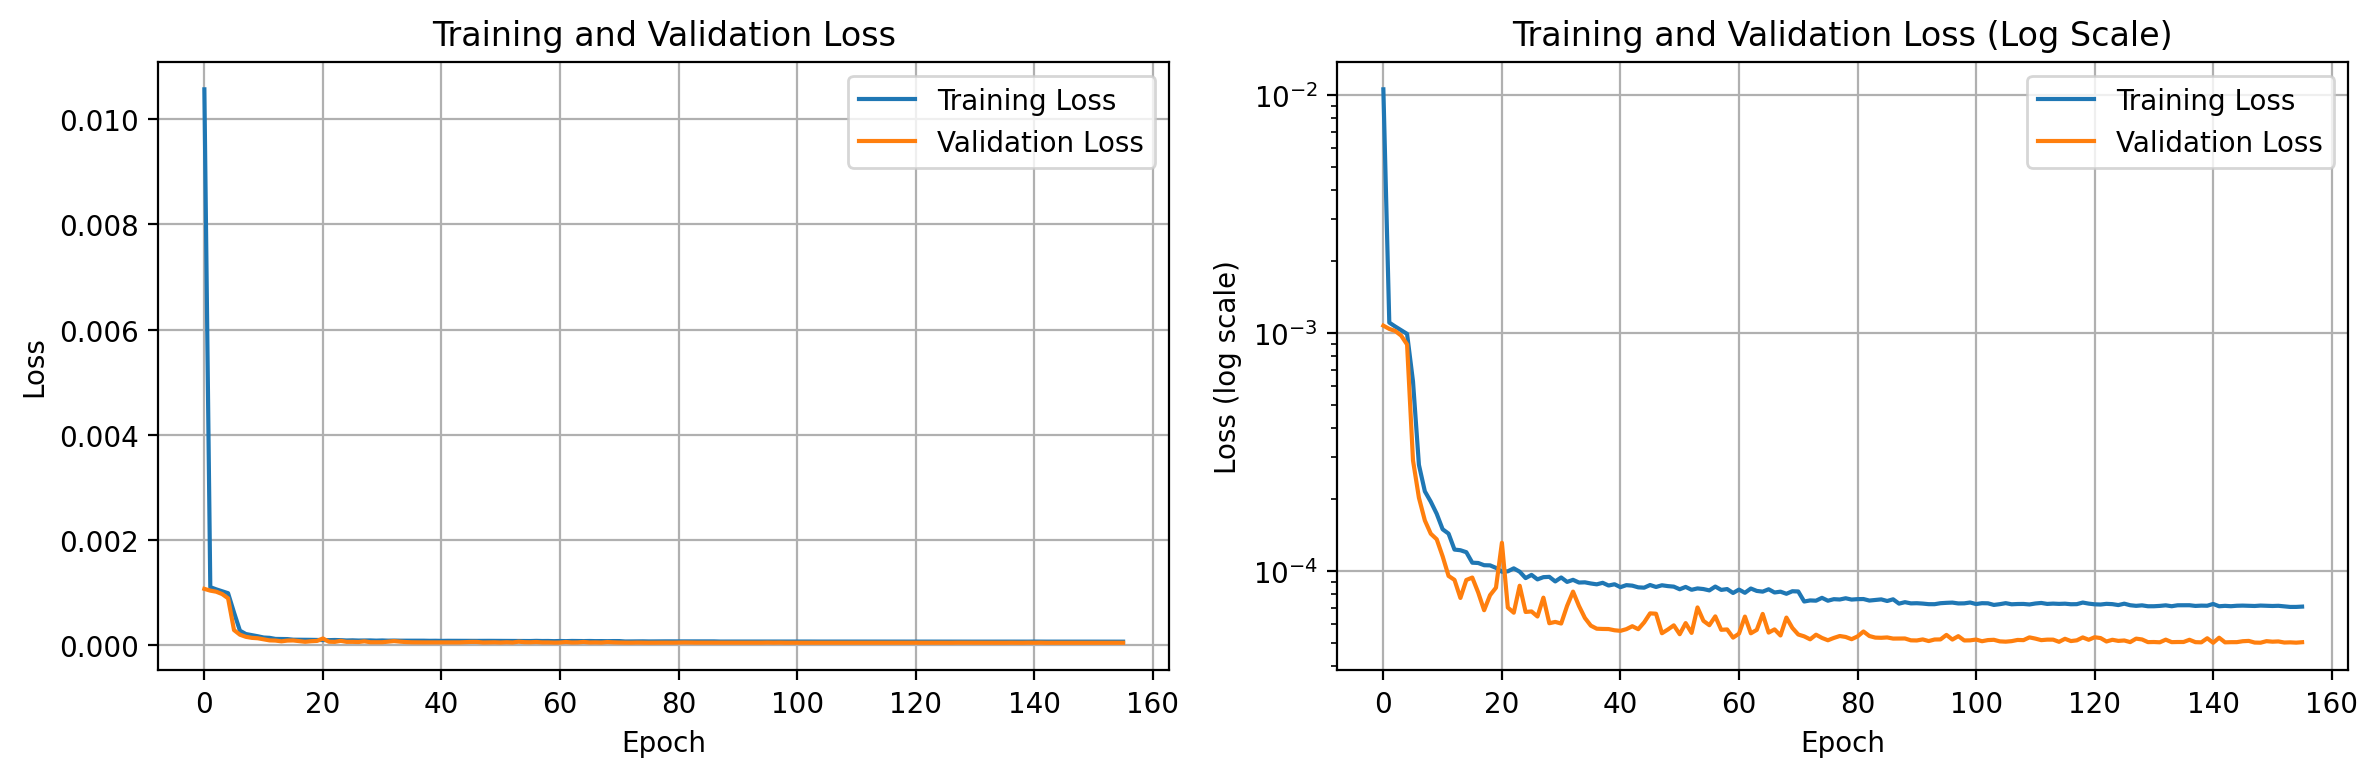

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.semilogy(train_losses, label='Training Loss')
plt.semilogy(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

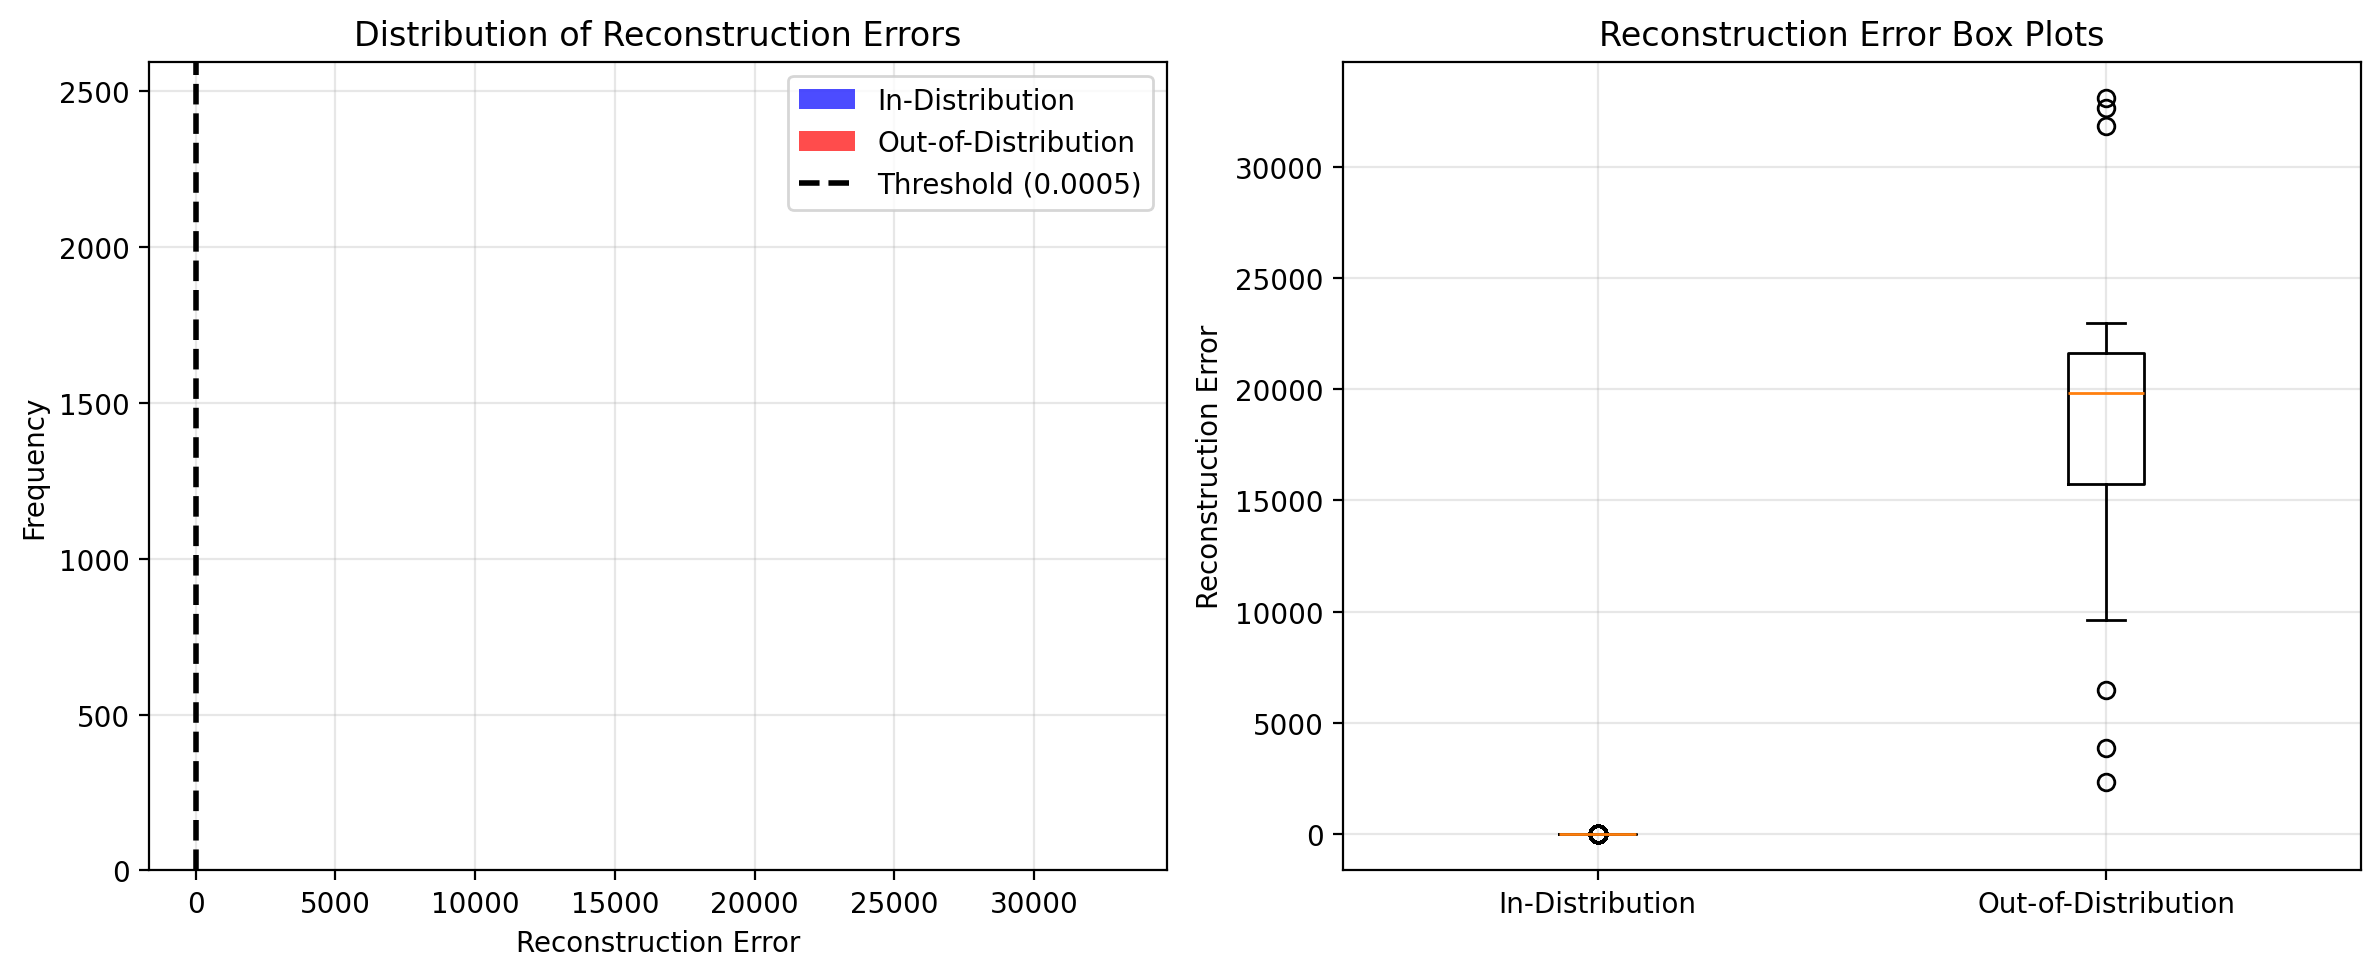

In [ ]:
# Plot reconstruction error distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
val_errors_in_dist = test_errors[test_labels == 0]
val_errors_ood = test_errors[test_labels == 1]

plt.hist(val_errors_in_dist, bins=50, alpha=0.7, label='In-Distribution', color='blue')
plt.hist(val_errors_ood, bins=50, alpha=0.7, label='Out-of-Distribution', color='red')
plt.axvline(best_threshold, color='black', linestyle='--', linewidth=2,
            label=f'Threshold ({best_threshold:.4f})')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([val_errors_in_dist, val_errors_ood],
            labels=['In-Distribution', 'Out-of-Distribution'])
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Box Plots')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

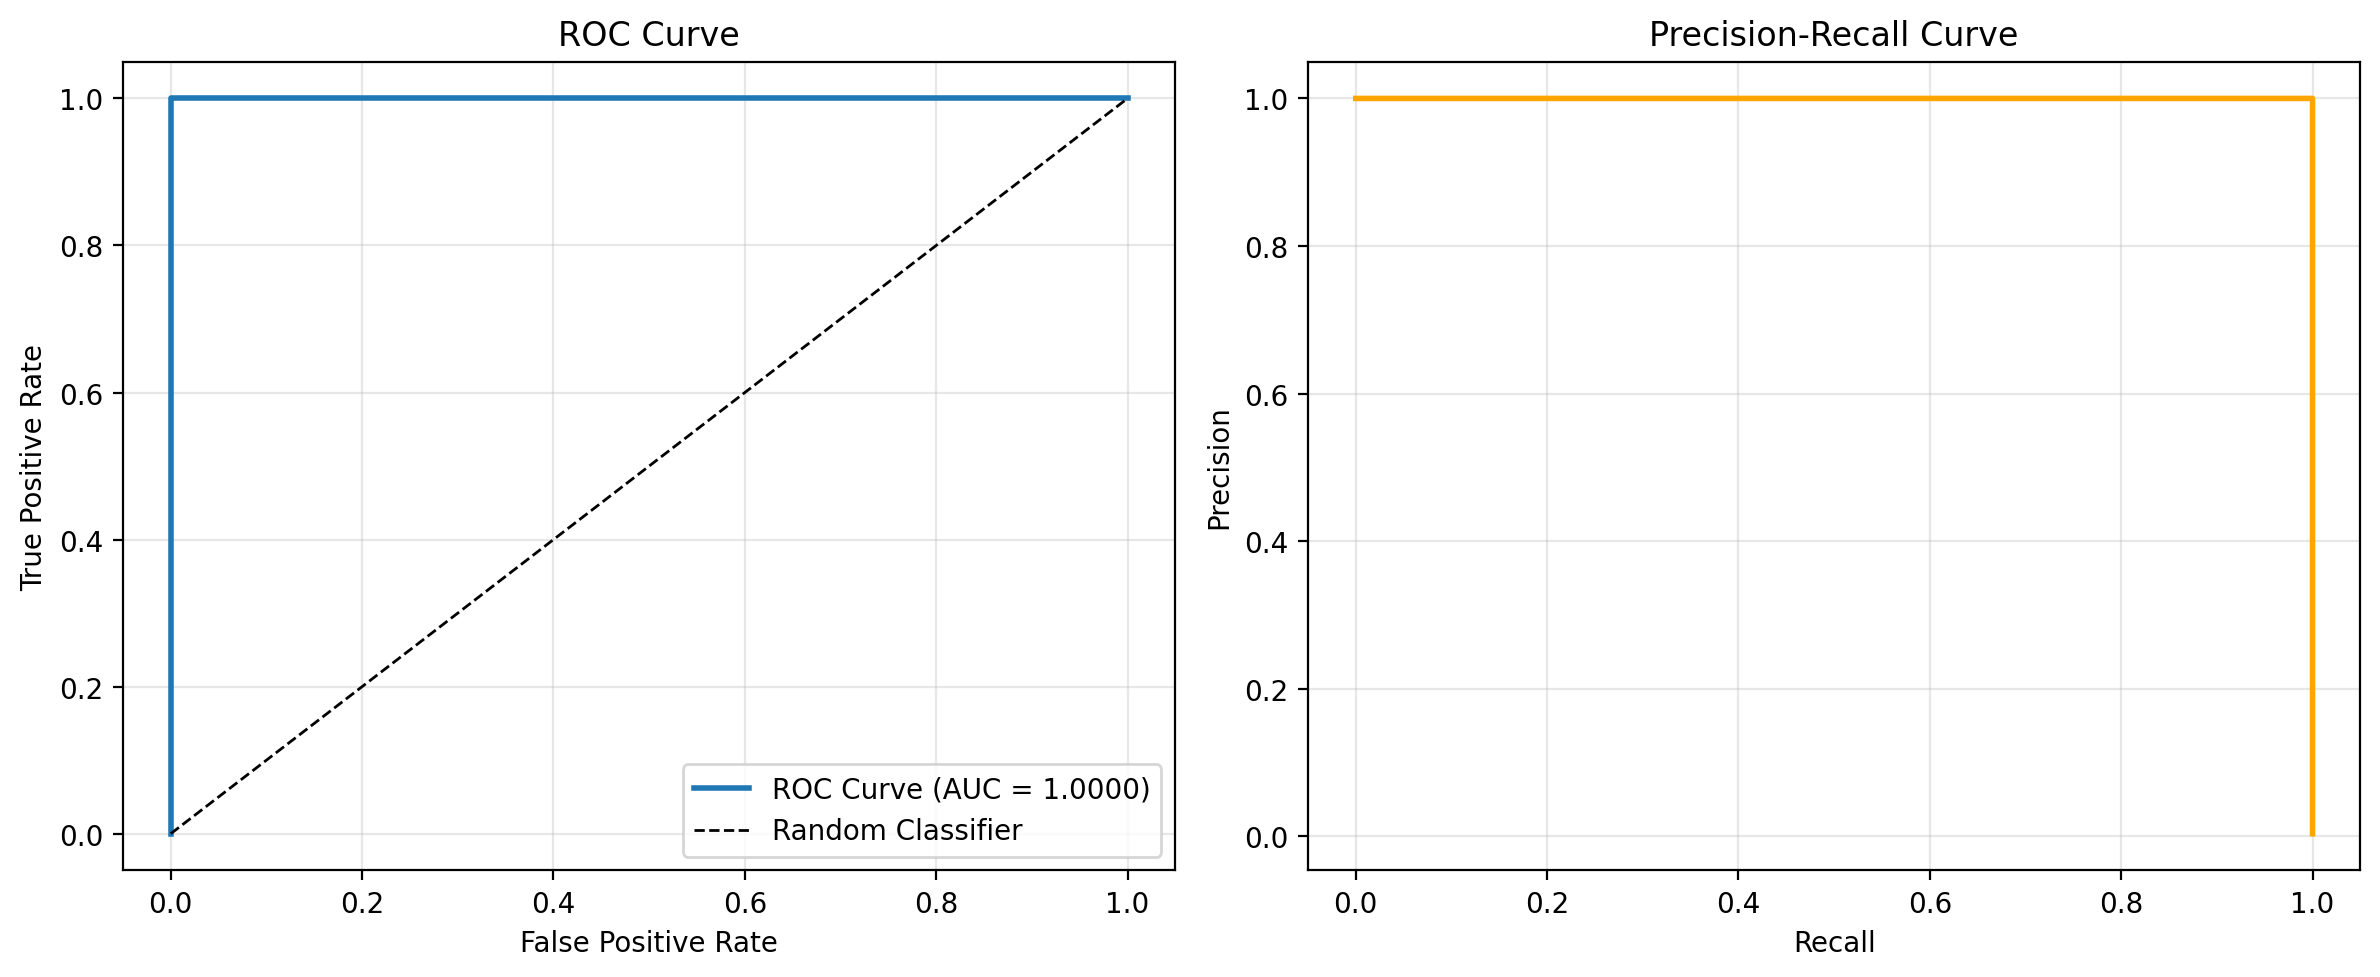

In [ ]:
# ROC and Precision-Recall curves
from sklearn.metrics import roc_curve, precision_recall_curve

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(test_labels, test_errors)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {final_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
precision_vals, recall_vals, _ = precision_recall_curve(test_labels, test_errors)
plt.plot(recall_vals, precision_vals, linewidth=2, color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

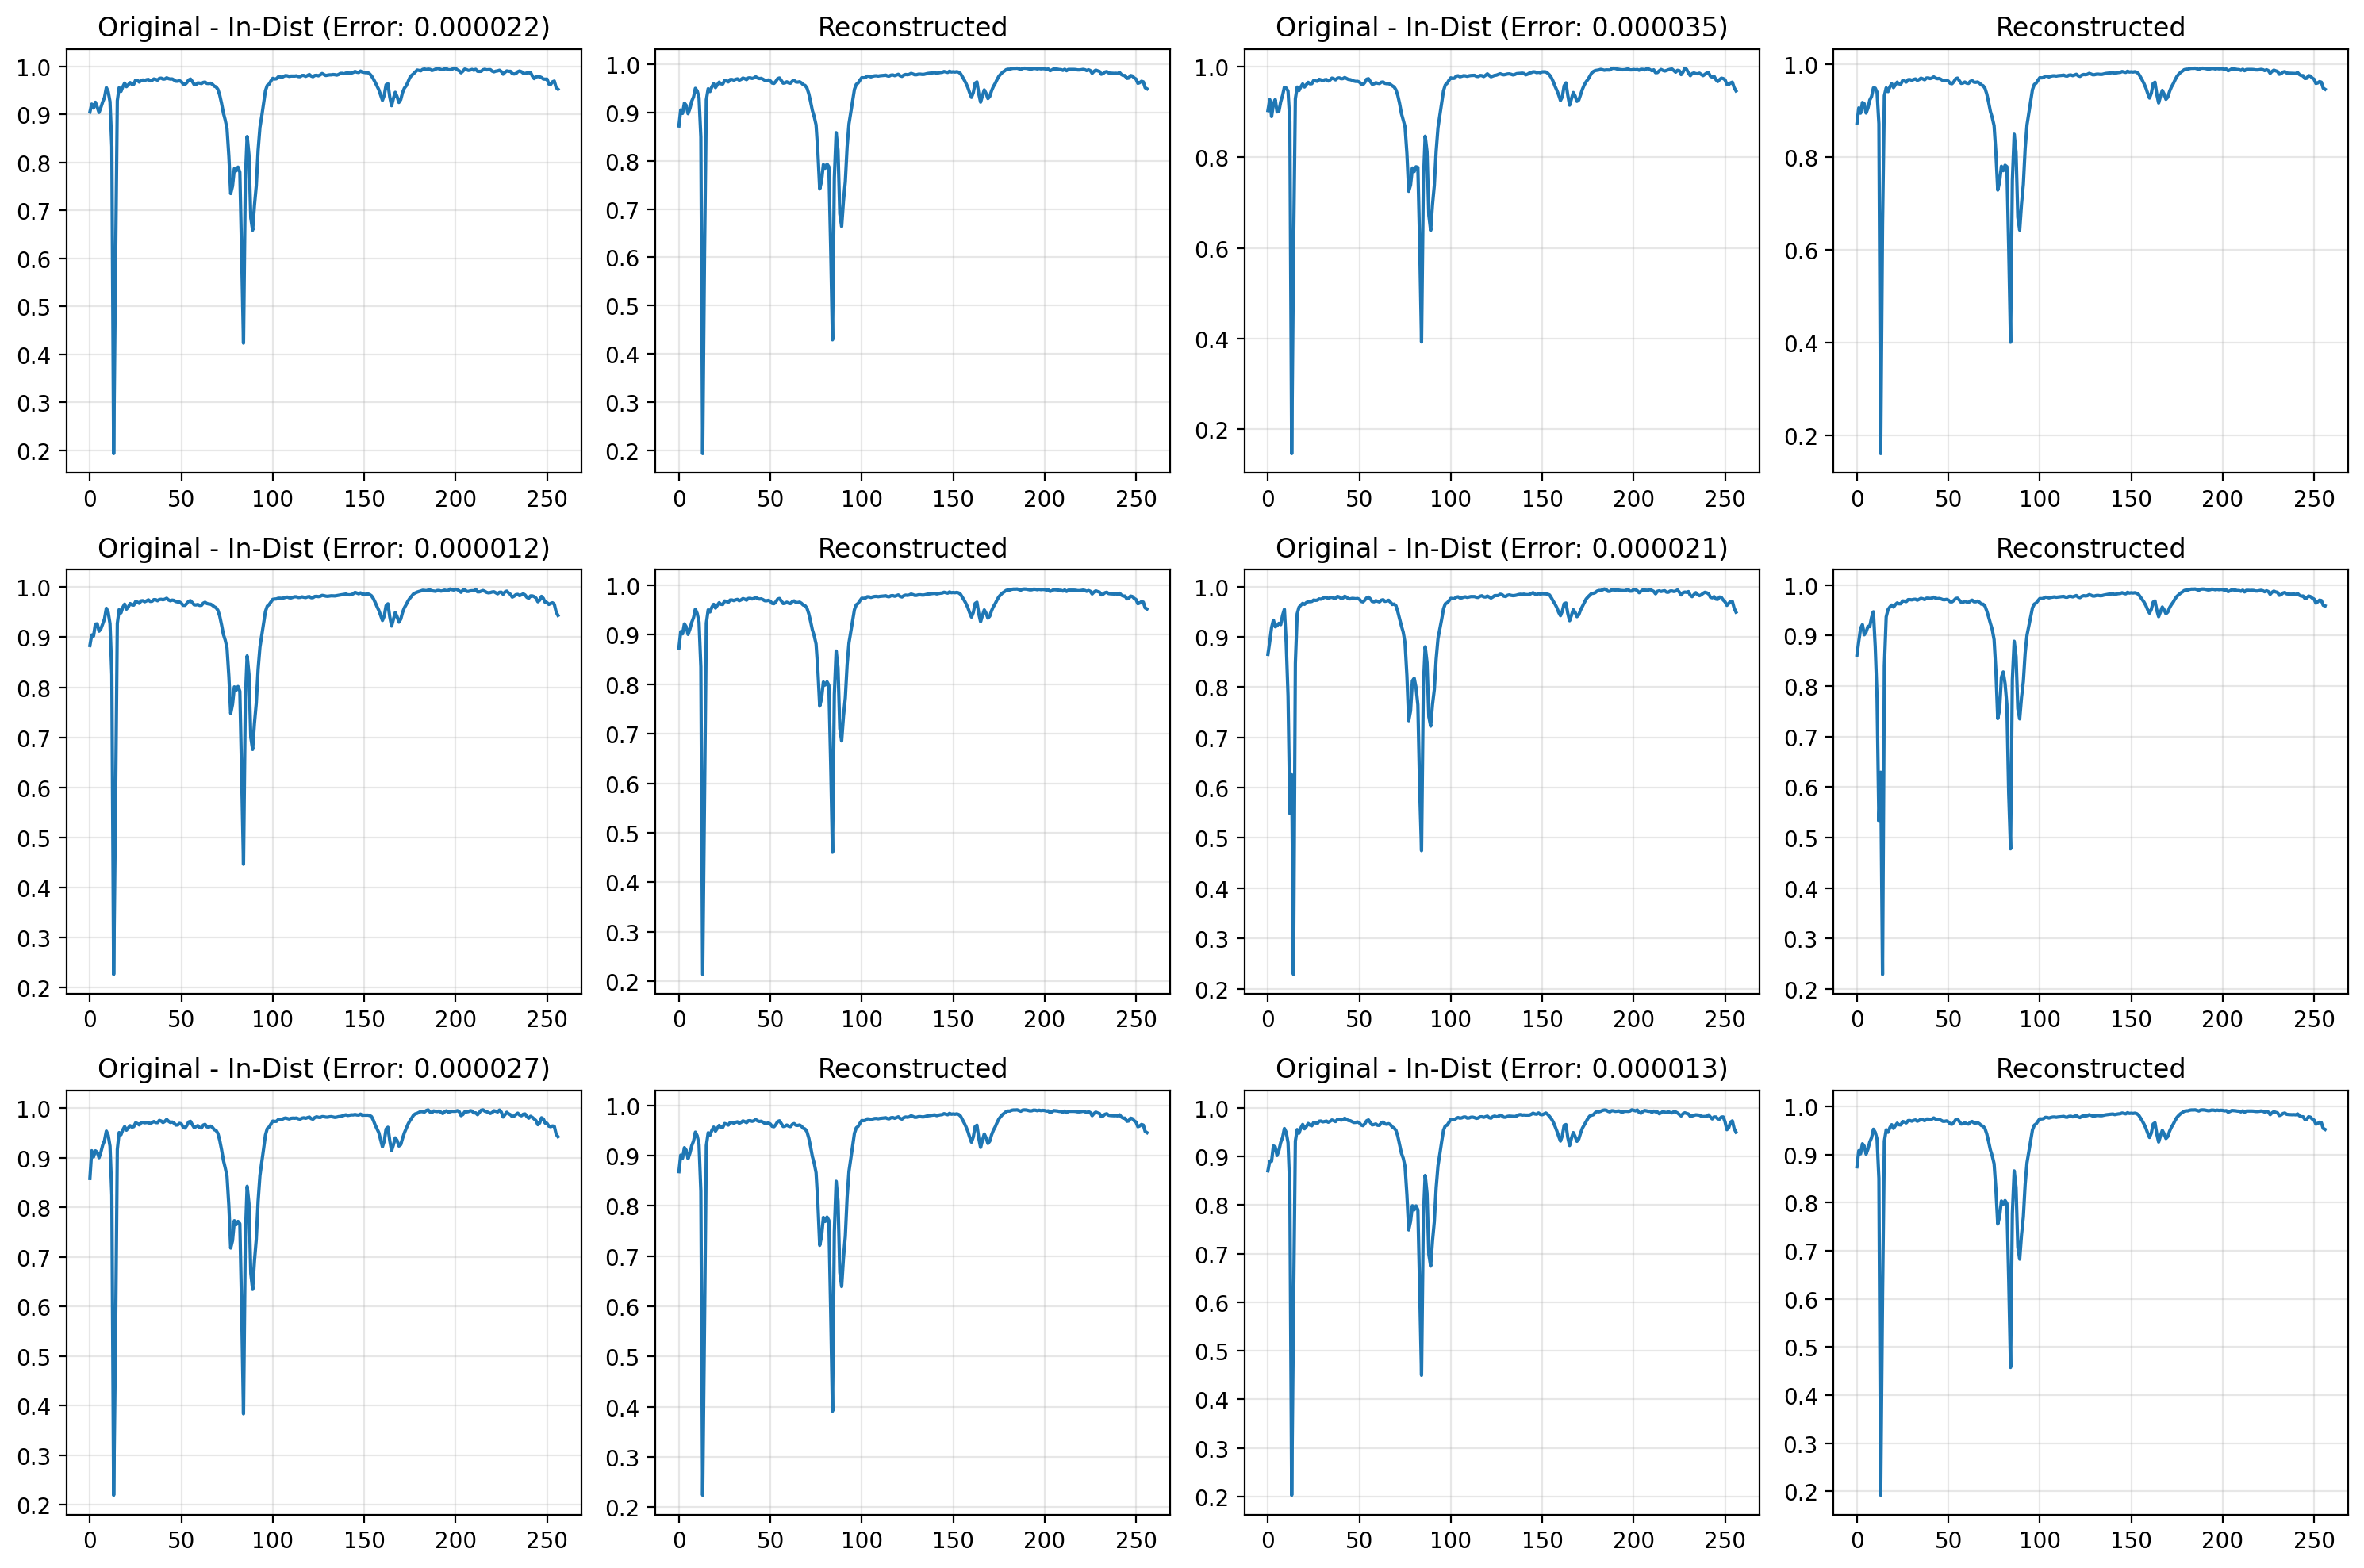

In [ ]:
# Show some reconstruction examples
model.eval()
with torch.no_grad():
    # Get a batch of test data
    test_batch, test_batch_labels = next(iter(test_loader))
    reconstructed_batch = model(test_batch)
    #print(reconstructed_batch.shape)

    # Calculate errors for this batch
    batch_errors = torch.mean((test_batch - reconstructed_batch) ** 2, dim=1)

    # Show examples
    plt.figure(figsize=(15, 10))

    for i in range(6):
        plt.subplot(3, 4, 2*i + 1)
        plt.plot(test_batch[i].cpu().numpy())
        plt.title(f'Original - {'In-Dist' if test_batch_labels[i] == 0 else 'OOD'} (Error: {batch_errors[i]:.6f})')
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 4, 2*i + 2)
        plt.plot(reconstructed_batch[i].cpu().numpy())
        plt.title('Reconstructed')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

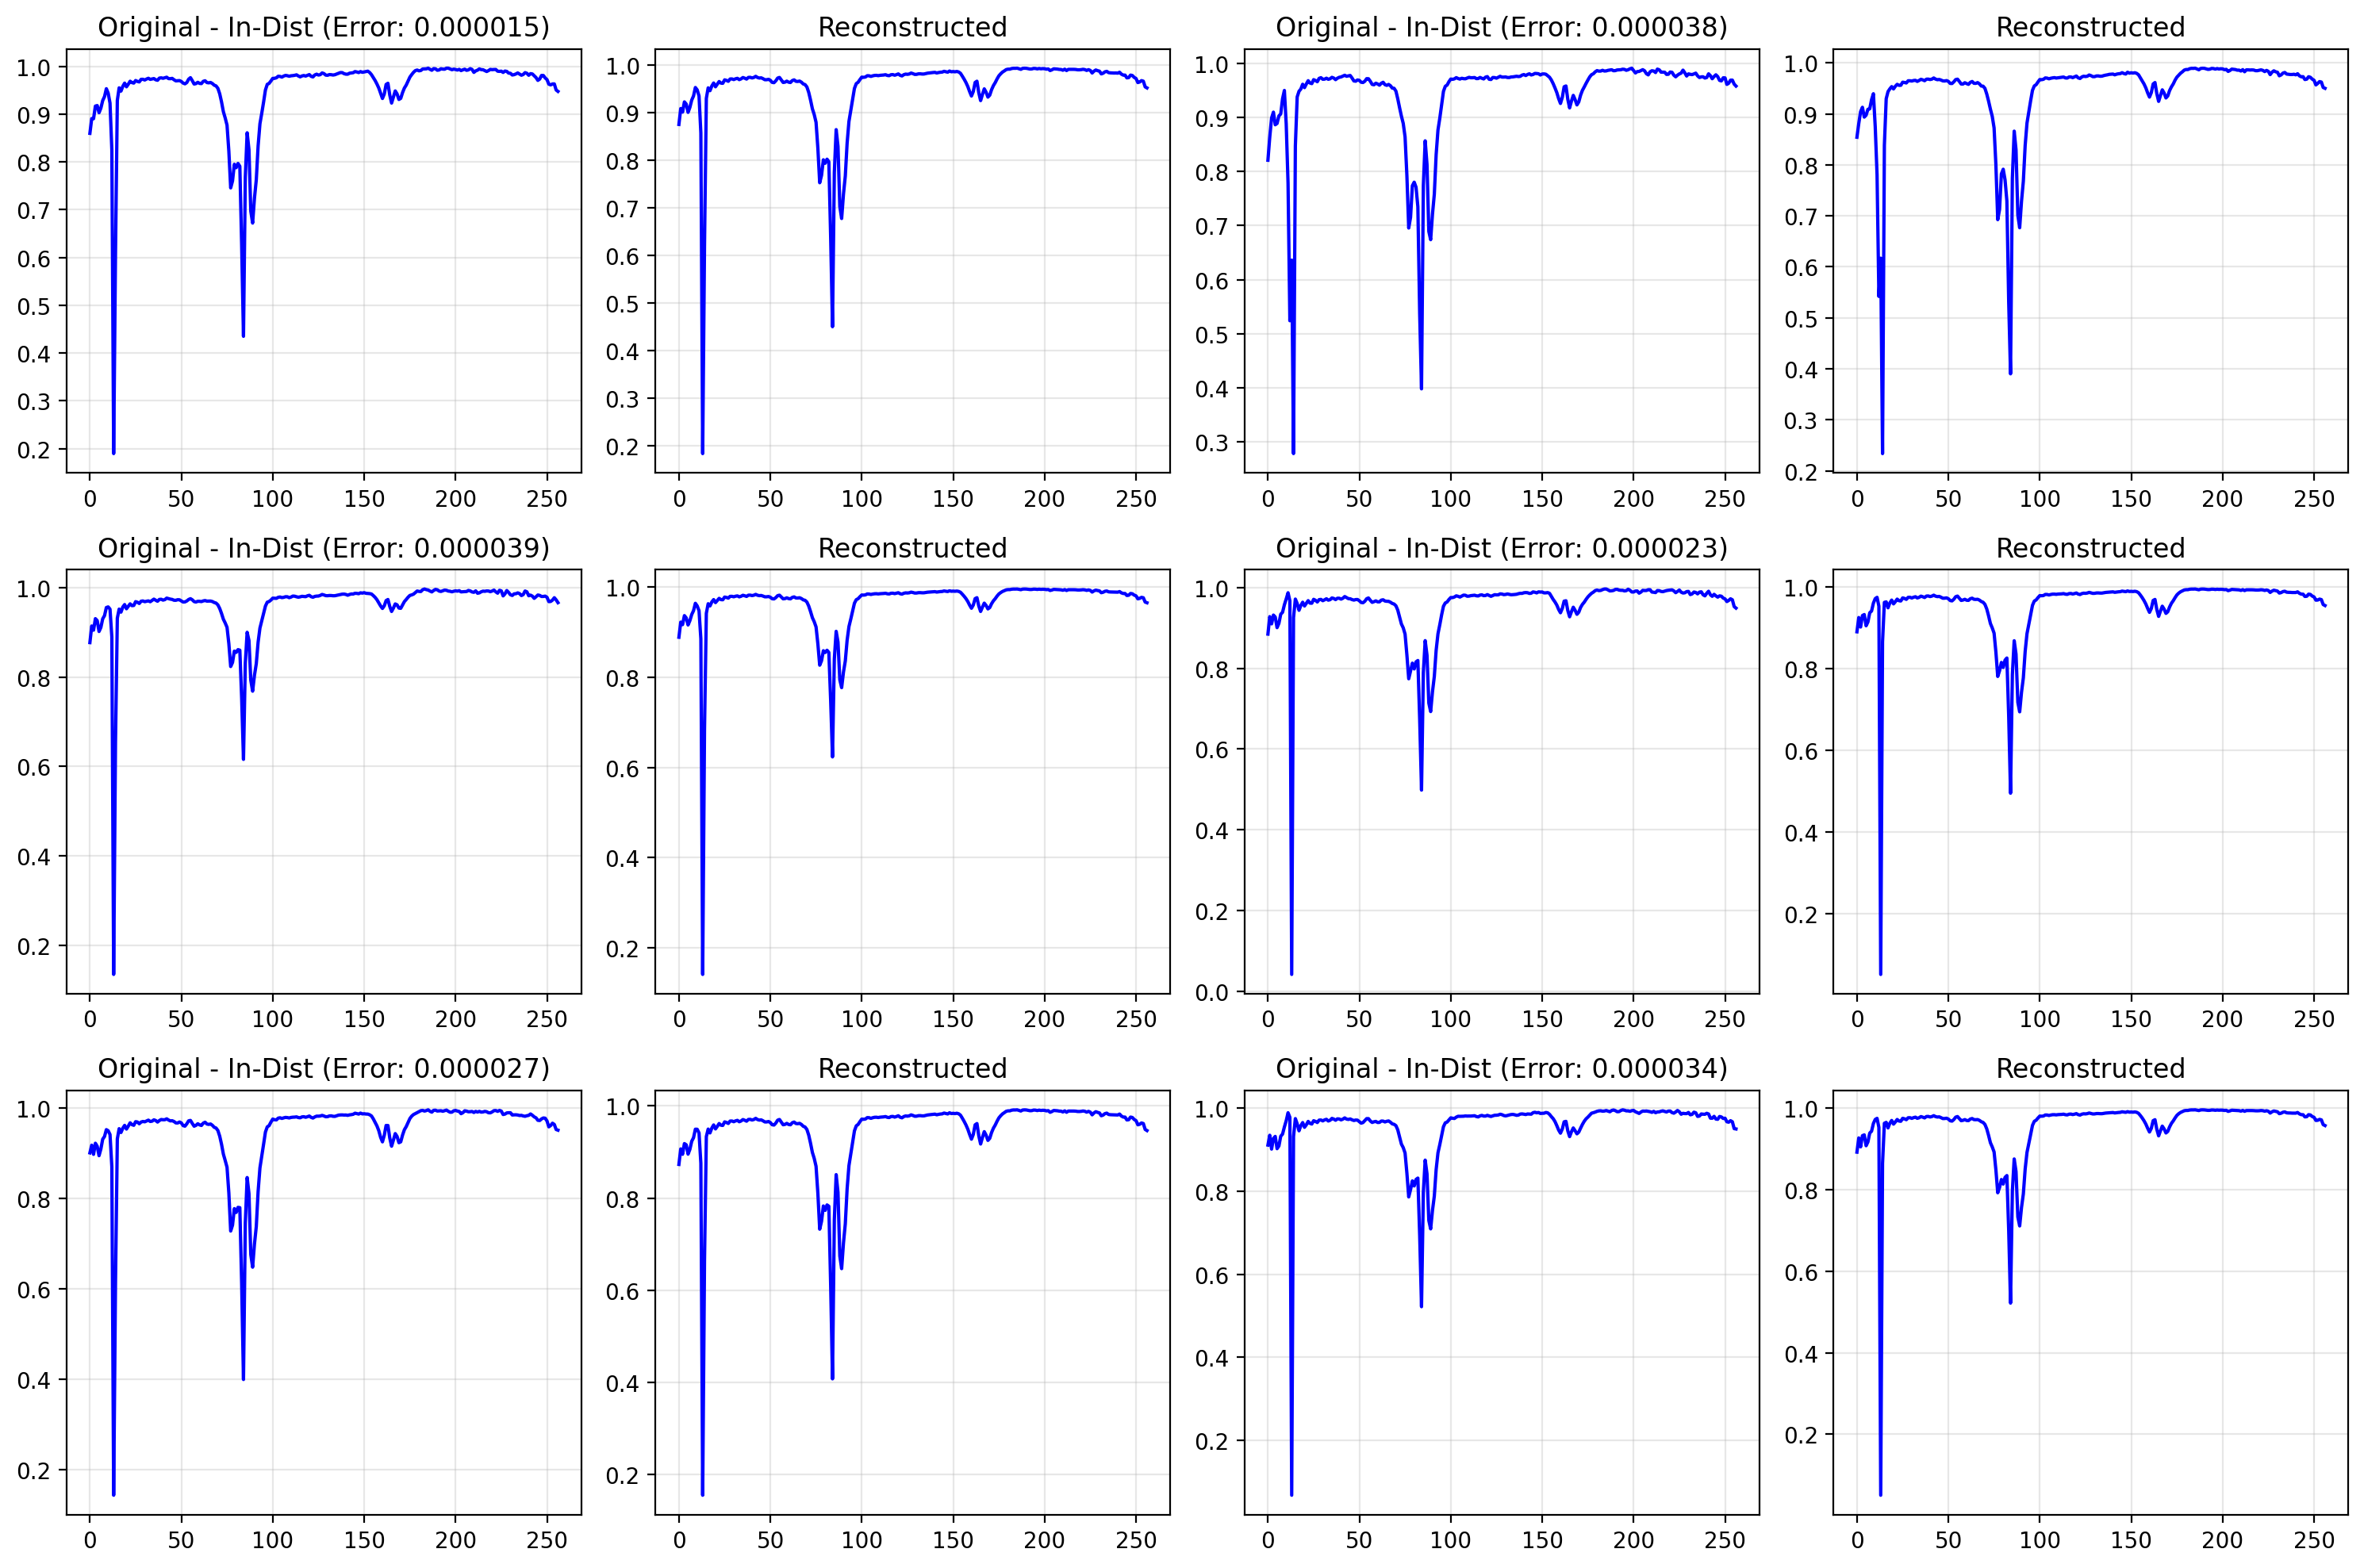

In [ ]:
# Show some reconstruction examples
model.eval()
with torch.no_grad():
    it = iter(test_loader)
    for _ in range(20):
        _, _ = next(it)
    # Get a batch of test data
    test_batch, test_batch_labels = next(it)
    reconstructed_batch = model(test_batch)
    #print(reconstructed_batch.shape)

    # Calculate errors for this batch
    batch_errors = torch.mean((test_batch - reconstructed_batch) ** 2, dim=1)

    # Show examples
    plt.figure(figsize=(15, 10))

    for i in range(6):
        plt.subplot(3, 4, 2*i + 1)
        color = 'r' if batch_errors[i] > best_threshold else 'b'
        plt.plot(test_batch[i].cpu().numpy(), c=color)
        plt.title(f'Original - {'In-Dist' if test_batch_labels[i] == 0 else 'OOD'} (Error: {batch_errors[i]:.6f})')
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 4, 2*i + 2)
        plt.plot(reconstructed_batch[i].cpu().numpy(), c=color)
        plt.title('Reconstructed')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 6. Summary and Conclusions

Summarize the findings and provide insights about the model's performance.

In [ ]:
print("=== Autoencoder Out-of-Distribution Detection Summary ===")
print()
print("Model Architecture:")
print("  - Input dimension: 257")
print("  - Latent dimension: 16")
print("  - Hidden layers: 128 → 64 → 32")
print()
print("Training Results:")
print(f"  - Best validation loss: {best_val_loss:.6f}")
print(f"  - Training epochs: {len(train_losses)}")
print()
print("OOD Detection Performance:")
print(f"  - Threshold: {best_threshold:.6f}")
print(f"  - Accuracy:  {final_accuracy:.4f}")
print(f"  - Precision: {final_precision:.4f}")
print(f"  - Recall:    {final_recall:.4f}")
print(f"  - F1-Score:  {final_f1:.4f}")
print(f"  - ROC-AUC:   {final_auc:.4f}")
print()

=== Autoencoder Out-of-Distribution Detection Summary ===

Model Architecture:
  - Input dimension: 257
  - Latent dimension: 16
  - Hidden layers: 128 → 64 → 32

Training Results:
  - Best validation loss: 0.000050
  - Training epochs: 156

OOD Detection Performance:
  - Threshold: 0.000497
  - Accuracy:  0.9899
  - Precision: 0.2474
  - Recall:    1.0000
  - F1-Score:  0.3967
  - ROC-AUC:   1.0000



In [ ]:
# Function to detect OOD samples in new data
def detect_ood_samples(model, data, threshold=best_threshold, scaler=scaler):
    """
    Detect out-of-distribution samples in new data

    Args:
        model: Trained autoencoder model
        data: New data (numpy array or DataFrame)
        threshold: Reconstruction error threshold for OOD detection
        scaler: Fitted scaler for data normalization

    Returns:
        predictions: Binary predictions (0 = in-dist, 1 = OOD)
        errors: Reconstruction errors for each sample
    """
    # Convert to numpy if DataFrame
    if isinstance(data, pd.DataFrame):
        data = data.values

    # Normalize data
    data_scaled = scaler.transform(data)

    # Convert to tensor
    data_tensor = torch.FloatTensor(data_scaled).to(device)

    # Calculate reconstruction errors
    model.eval()
    with torch.no_grad():
        reconstructed = model(data_tensor)
        errors = torch.mean((data_tensor - reconstructed) ** 2, dim=1)
        errors = errors.cpu().numpy()

    # Make predictions
    predictions = (errors > threshold).astype(int)

    return predictions, errors


In [ ]:
# Function to detect OOD samples in new data
def detect_ood_samples_no_scaling(model, data, threshold=best_threshold):
    """
    Detect out-of-distribution samples in new data

    Args:
        model: Trained autoencoder model
        data: New data (numpy array or DataFrame)
        threshold: Reconstruction error threshold for OOD detection

    Returns:
        predictions: Binary predictions (0 = in-dist, 1 = OOD)
        errors: Reconstruction errors for each sample
    """
    # Convert to numpy if DataFrame
    if isinstance(data, pd.DataFrame):
        data = data.values

    # Convert to tensor
    data_tensor = torch.FloatTensor(data).to(device)

    # Calculate reconstruction errors
    model.eval()
    with torch.no_grad():
        reconstructed = model(data_tensor)
        errors = torch.mean((data_tensor - reconstructed) ** 2, dim=1)
        errors = errors.cpu().numpy()

    # Make predictions
    predictions = (errors > threshold).astype(int)

    return predictions, errors

In [ ]:
detect_ood_samples(model, ood_df)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([ 9639.349 ,  3868.0881,  6451.9985,  2310.0828, 11515.914 ,
        11818.965 , 31850.42  , 21508.252 , 21163.701 , 21131.773 ,
        20690.68  , 19748.48  , 32654.498 , 33099.594 , 19916.457 ,
        22002.105 , 22182.252 , 22969.373 , 17020.596 , 17936.156 ,
        18042.479 , 19626.326 , 19560.998 , 20350.56  ], dtype=float32))

In [ ]:
detect_ood_samples(model, in_dist_df)

(array([0, 1, 0, ..., 0, 0, 0], shape=(36149,)),
 array([3.2109214e-04, 2.0171271e-01, 3.9973276e-04, ..., 6.9502632e-05,
        6.4729247e-05, 7.3648051e-05], shape=(36149,), dtype=float32))

In [ ]:
samples_df = pd.read_csv('data/collected/AQPracticalGasesSamples_20251116.csv').iloc[:, 14:257+14]
#samples_df = pd.read_csv('data/collected/4th-floor-production-lab-20251127-unknown-gases-included.csv').iloc[:, 11:257+11]
results = detect_ood_samples(model, samples_df)
np.sum(results[0])

np.int64(24)

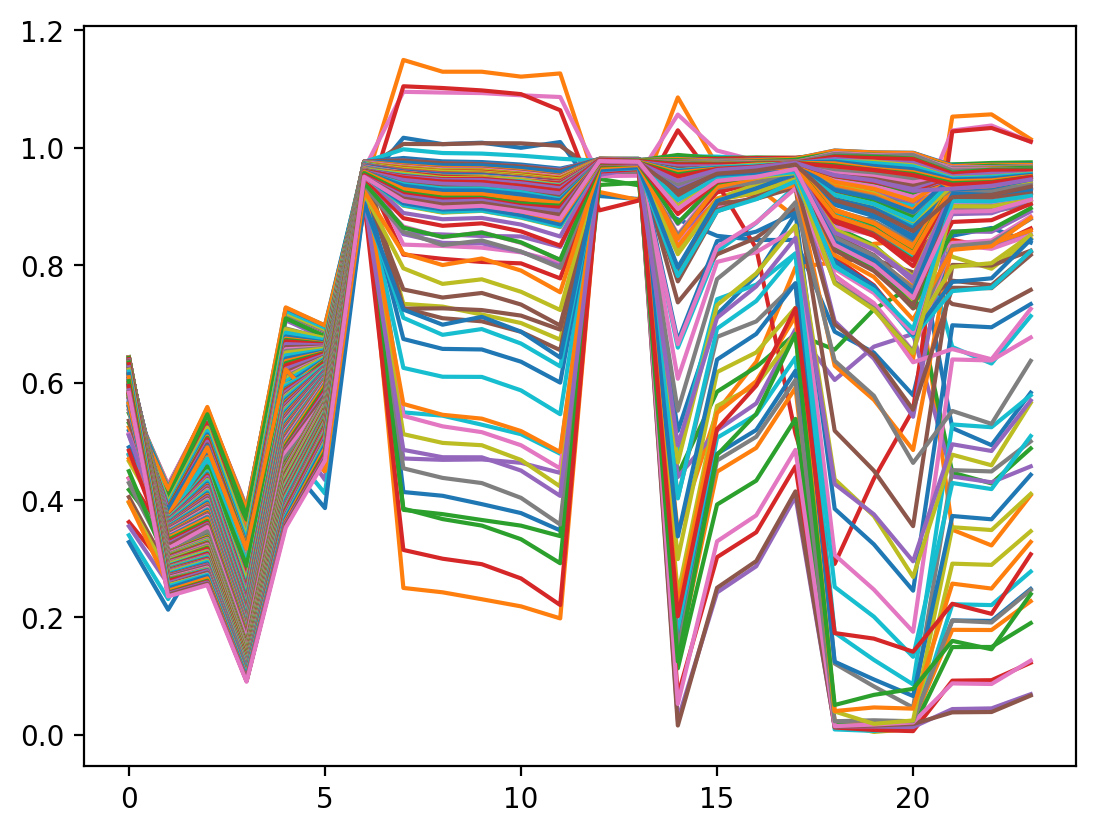

In [ ]:
plt.plot(samples_df.values / 100);

In [ ]:
detect_ood_samples_no_scaling(model, samples_df.values / 100, 0.01)

(array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1]),
 array([0.06660774, 0.22223255, 0.25317854, 0.3198201 , 0.1883267 ,
        0.10753881, 0.00305577, 0.00490104, 0.00496731, 0.00520739,
        0.00537424, 0.00562255, 0.00279763, 0.00295478, 0.03787675,
        0.0174662 , 0.01507229, 0.00984224, 0.05332022, 0.05420683,
        0.05448195, 0.03380082, 0.03409023, 0.03105319], dtype=float32))

In [ ]:
detect_ood_samples_no_scaling(model, samples_df.values / 100, 0.02)

(array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1]),
 array([0.06660774, 0.22223255, 0.25317854, 0.3198201 , 0.1883267 ,
        0.10753881, 0.00305577, 0.00490104, 0.00496731, 0.00520739,
        0.00537424, 0.00562255, 0.00279763, 0.00295478, 0.03787675,
        0.0174662 , 0.01507229, 0.00984224, 0.05332022, 0.05420683,
        0.05448195, 0.03380082, 0.03409023, 0.03105319], dtype=float32))

In [ ]:
detect_ood_samples_no_scaling(model, samples_df.values / 100, 0.03)

(array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1]),
 array([0.06660774, 0.22223255, 0.25317854, 0.3198201 , 0.1883267 ,
        0.10753881, 0.00305577, 0.00490104, 0.00496731, 0.00520739,
        0.00537424, 0.00562255, 0.00279763, 0.00295478, 0.03787675,
        0.0174662 , 0.01507229, 0.00984224, 0.05332022, 0.05420683,
        0.05448195, 0.03380082, 0.03409023, 0.03105319], dtype=float32))

In [ ]:
detect_ood_samples_no_scaling(model, samples_df.values / 100, 0.04)

(array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0]),
 array([0.06660774, 0.22223255, 0.25317854, 0.3198201 , 0.1883267 ,
        0.10753881, 0.00305577, 0.00490104, 0.00496731, 0.00520739,
        0.00537424, 0.00562255, 0.00279763, 0.00295478, 0.03787675,
        0.0174662 , 0.01507229, 0.00984224, 0.05332022, 0.05420683,
        0.05448195, 0.03380082, 0.03409023, 0.03105319], dtype=float32))